# **Projet 10** : Détecter des faux billets avec Python

## **Objectifs :** 

Lutter contre le faux-monnayage en mettant en place un modèle permettant d'identifier les vrais et faux billets.

- Effectuer une régression linéaire ou multiple pour combler les valeurs manquantes dans nos données
- Utiliser 2 modèles de prédictions pour détecter les faux billets : méthode des k-means et régression logistique
- Selectionner le modèle le plus performant

In [2]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Modèles et algorithmes
from scipy.stats import shapiro, t, probplot
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, silhouette_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols

# Sauvegarde du modèle
from joblib import dump, load

In [22]:
# Données à dispostion

df = pd.read_csv("billets.csv", sep=";")

In [23]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [24]:
# Affiche le nombre de valeurs uniques
df.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [25]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Notre dataframe **df** contient : 
- **1500 billets**, un par ligne
- **7 variables** différentes :
    - la variable **"is_genuine"** de type booléen pour spécifier **l'authenticité d'un billet** (True ou False)
    - **6 autres variables numériques (Float)** indiquant les mesures et dimensions des billets

In [26]:
# Affiche le nombre de valeurs manquantes
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il manque **37** valeurs dans la colonne **'margin_low'**.


Ces **valeurs manquantes** seront traitées à l'aide d'une **regression linéaire** simple ou multiple, cela reste à déterminer.

Au vue du nombre de variables que contient le dataframe et de leur relation potentielle entre elles (dimensions, mesures), nous partiront sur **la régression linéaire multiple**.

In [27]:
# Transformer la colonne 'is_genuine' en valeur numérique
df['is_genuine'] = df['is_genuine'] * 1

df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


**'is_genuine'** est converti en valeur numérique avec **1 = Vrai**, **0 = Faux**.

### Regression linéaire

Nous retirerons du modèle **chaque variable ayant une P-valeur >0,05** car elles ne sont **pas statistiquement significative**, en commençant par la plus élevée.

Elles n'ont **aucun impact** sur la **prédiction de 'margin_low'**.

In [28]:
def backward_elimination(data, response, p_value_threshold=0.05):
    features = data.columns.drop(response)
    while len(features) > 0:
        features_to_test = '+'.join(features)
        formula = f"{response} ~ {features_to_test}"
        model = ols(formula, data=data).fit()

        # Excluez l'intercept des résultats p-value
        p_values = model.pvalues.drop('Intercept')

        max_p_value = p_values.max()  # get the variable with the highest p-value
        if max_p_value >= p_value_threshold:
            excluded_feature = p_values.idxmax()
            features = features.drop(excluded_feature)
            print(f"\nVariable exclue : {excluded_feature} avec p-value {max_p_value:.4f}")
            print(f"Variables restantes : {features.to_list()}\n")
        else:
            break
    
    final_features_to_test = '+'.join(features)
    final_formula = f"{response} ~ {final_features_to_test}"
    final_model = ols(final_formula, data=data).fit()
    
    return final_model

model = backward_elimination(df, 'margin_low')
print(model.summary())


Variable exclue : length avec p-value 0.8685
Variables restantes : ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up']


Variable exclue : diagonal avec p-value 0.7191
Variables restantes : ['is_genuine', 'height_left', 'height_right', 'margin_up']


Variable exclue : height_right avec p-value 0.4960
Variables restantes : ['is_genuine', 'height_left', 'margin_up']


Variable exclue : height_left avec p-value 0.4544
Variables restantes : ['is_genuine', 'margin_up']

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Wed, 17 Jan 2024   Prob (F-statistic):          1.24e-304
Time:                        20:59:44   Log-Likelihood:                -774.73
No. Observations:                146

Après avoir **simplifier le modèle de regression linéaire multiple** et **améliorer sa précision**, nous gardons uniquement les variables : **'margin_up'** et **'is_genuine'** pour **prédire les valeurs manquantes de 'margin_low'**.

### Analyse des résidus 

L'analyse des résidus est **cruciale dans la modélisation de régression** car elle permet **d'évaluer la qualité de l'ajustement du modèle aux données** et **d'identifier d'éventuelles violations des hypothèses** de la régression linéaire.

In [29]:
# Reprenons notre régression linéaire multiple 

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Wed, 17 Jan 2024   Prob (F-statistic):          1.24e-304
Time:                        20:59:49   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9263      0.198     30.003      0.0

In [30]:
# Nous allons ici réaliser les tests à un niveau 𝛼 = 5%

alpha = 0.05

# Récupérons n, le nombre d'individus de l'échantillon, et p, le nombre de variables.
# Ainsi que n_obs, le nombre d'observations

n = df.shape[0]
n_obs = model.nobs
p = 3

Nous allons mener des analyses sur **les valeurs atypiques et/ou influentes** en travaillant sur un dataframe appelé  **analyses**.

In [31]:
analyses = pd.DataFrame({'obs':np.arange(1, n_obs+1)})

#### Calcul des leviers

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

- Les observations avec des valeurs de levier élevées sont celles qui ont une influence disproportionnée sur l'ajustement du modèle.
- Comme règle générale, une valeur de levier qui dépasse le seuil est considérée comme potentiellement influente.
- Si vous identifiez des observations avec un levier élevé, vous voudrez peut-être les examiner de plus près pour déterminer si elles sont des valeurs aberrantes ou si elles exercent une influence indue sur le modèle.

In [32]:
analyses['levier'] = model.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

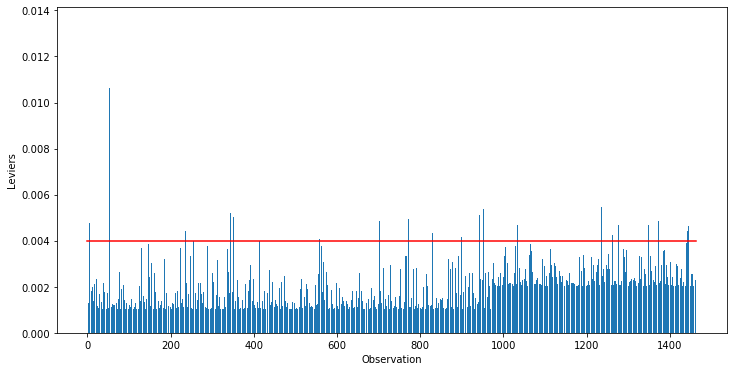

In [33]:
plt.figure(figsize=(12,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, n_obs, step=200))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n_obs], [seuil_levier, seuil_levier], color='r')
plt.show()

#### Calcul des résidus studentisés

Les résidus studentisés sont une version standardisée des résidus qui permettent de détecter des observations qui ont un comportement anormal par rapport à l'ajustement du modèle.

Si l'on souhaite maintenant les calculer, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté

In [34]:
analyses['rstudent'] = model.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

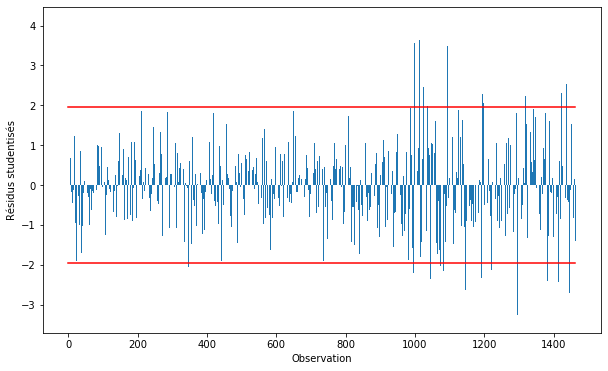

In [35]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, n_obs, step=200))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n_obs], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n_obs], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

**Différences intrinsèques** : Si les faux billets ont des caractéristiques géométriques qui diffèrent systématiquement des vrais billets, et que ces caractéristiques ne sont pas complètement capturées par les variables incluses dans le modèle, les résidus pour ces observations pourraient naturellement être plus élevés.

**Modèle sous-spécifié** : Le modèle peut ne pas inclure toutes les variables pertinentes qui expliquent 'margin_low' pour les faux billets. Il peut y avoir d'autres facteurs non mesurés ou non inclus qui influencent 'margin_low' différemment pour les faux billets.

**Échantillon hétérogène** : Si les faux billets constituent un échantillon hétérogène avec une plus grande variance dans les caractéristiques mesurées, cela peut également entraîner des résidus plus élevés car le modèle est basé sur des moyennes et pourrait ne pas bien saisir cette variabilité.

#### Calcul de la distance de Cook


In [36]:
influence = model.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p. 

In [37]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

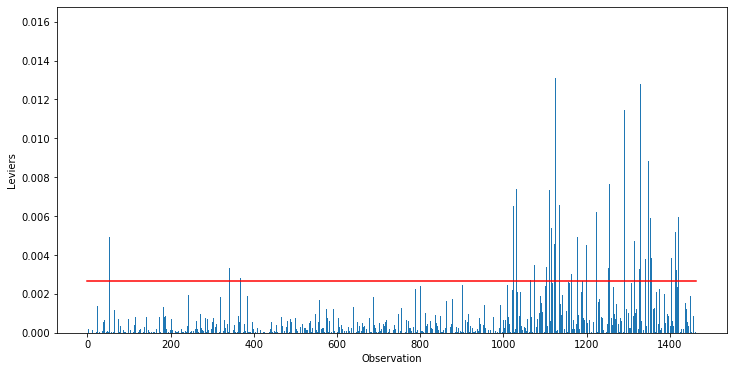

In [38]:
plt.figure(figsize=(12,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, n_obs, step=200))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n_obs], [seuil_dcook, seuil_dcook], color='r')
plt.show()

#### Vérifier la colinéarité des variables

In [39]:
variables = model.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5938854494007753, 1.5938854494007746]

Ici, tous les coefficients sont **inférieurs à 10**, il n'y a donc **pas de problème de colinéarité**.

#### Testez l’homoscédasticité

Vérifions **l'homoscédasticité** (c'est-à-dire la constance de la variance) de nos résidus avec le **test de Breusch-Pagan**

Nos hypothèses sont les suivantes : 

- Hypothèse nulle (***H0***) : Il n'y a **pas d'hétéroscédasticité** (c'est-à-dire, la variance des résidus est constante).
- Hypothèse alternative (***H1***) : Il y a de l'**hétéroscédasticité** (c'est-à-dire, la variance des résidus varie avec les niveaux de la variable indépendante ou les prédictions).

In [21]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(model.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.203355911585938e-36
